<a href="https://colab.research.google.com/github/masterschool-content/retail_demand_forecast/blob/main/EDA_with_pandas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import all libraries we will need


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Connect to Goole Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Read the files with pandas

In [3]:
# Load the CSV files into pandas DataFrames
df_stores = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/stores.csv')
df_items = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/items.csv')
df_transactions = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/transactions.csv')
df_oil = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/oil.csv')
df_holidays_events = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/holidays_events.csv')

#Note: train file is very large.
#To make sure we fit RAM avaible on Google-Colab, we will load only part of the file
df_train = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/train.csv', nrows=2.0e7)

In [4]:
df_items.head(5)

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


In [5]:
df_stores.head(5)

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [6]:
df_train['store_nbr'].nunique(), df_stores['store_nbr'].nunique()

(47, 54)

In [7]:
df_train['item_nbr'].nunique(), df_items['item_nbr'].nunique()

(2654, 4100)

In [8]:
df_transactions.head(5)

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [9]:
df_oil.head(7)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
5,2013-01-08,93.21
6,2013-01-09,93.08


In [10]:
df_holidays_events.head(5)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [11]:
df_train['store_nbr'].nunique()

47

## Checking missing values

In [12]:
# Count missing values per column
missing_values = df_train.isna().sum()

# Print the result
print(missing_values)

id                    0
date                  0
store_nbr             0
item_nbr              0
unit_sales            0
onpromotion    20000000
dtype: int64


In [13]:
# Focusing on missing values in the 'onpromotion' column
df_train['onpromotion'] = df_train['onpromotion'].fillna(False).astype(bool)

<ipython-input-13-7bdead4240c5>:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train['onpromotion'] = df_train['onpromotion'].fillna(False).astype(bool)


### **Challenge 1: Checking for Missing Data**

Other files might contain the missing data too. Check each of them and and think what would be a best way to deal with such data (cleaning, filling up with default values or something else)?

# Handling Outliers

## Negative sales

In [14]:
# Checking for negative sales (returns)
negative_sales = df_train[df_train['unit_sales'] < 0]

# Replacing negative sales with 0 to reflect returns as non-sales
df_train['unit_sales'] = df_train['unit_sales'].apply(lambda x: max(x, 0))

negative_sales.head()  # Viewing negative sales for analysis

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
10655,10655,2013-01-02,10,456875,-3.0,False
46867,46867,2013-01-03,5,559044,-1.0,False
50970,50970,2013-01-03,9,365138,-3.0,False
71807,71807,2013-01-03,41,812716,-19.0,False
71992,71992,2013-01-03,41,1004551,-27.0,False


## Extremely high sales

In [15]:
# Function to calculate Z-score for each group (store-item combination)
def calculate_store_item_zscore(group):
    # Compute mean and standard deviation for each store-item group
    mean_sales = group['unit_sales'].mean()
    std_sales = group['unit_sales'].std()

    # Calculate Z-score (avoiding division by zero for standard deviation)
    group['z_score'] = (group['unit_sales'] - mean_sales) / (std_sales if std_sales != 0 else 1)
    return group


# Apply the Z-score calculation to each store-item group without resetting the index
df_train_grouped = df_train.groupby(['store_nbr', 'item_nbr']).apply(calculate_store_item_zscore)
df_train_grouped = df_train_grouped.reset_index(drop=True)

# Define threshold for outliers (e.g., Z-score > 5)
outliers = df_train_grouped[df_train_grouped['z_score'] > 5]

# Print summary
print(f"Number of outliers detected: {len(outliers)}")
outliers.head()

<ipython-input-15-47574a334bea>:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train_grouped = df_train.groupby(['store_nbr', 'item_nbr']).apply(calculate_store_item_zscore)


Number of outliers detected: 42604


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,z_score
185,1752224,2013-02-14,1,103520,19.0,False,6.351089
403,15696569,2013-12-19,1,103520,19.0,False,6.351089
406,15906356,2013-12-23,1,103520,20.0,False,6.747452
1755,9360518,2013-08-07,1,105577,11.0,False,5.436540
1988,19261352,2014-02-21,1,105693,5.0,False,6.418964


# Feature Engineering

In [16]:
# Convert date column to datetime
df_train['date'] = pd.to_datetime(df_train['date'])
print("Data range: from",df_train['date'].dt.date.min(),"till",df_train['date'].dt.date.max())

Data range: from 2013-01-01 till 2014-03-06


In [17]:
# Creating new time-based features
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day'] = df_train['date'].dt.day
df_train['day_of_week'] = df_train['date'].dt.dayofweek

# Calculating rolling average of unit_sales
df_train['unit_sales_7d_avg'] = df_train.groupby(['item_nbr', 'store_nbr'])['unit_sales'].transform(lambda x: x.rolling(window=7).mean())

In [18]:
#df_train.sample(frac=0.1).compute()

# Visualizing Data

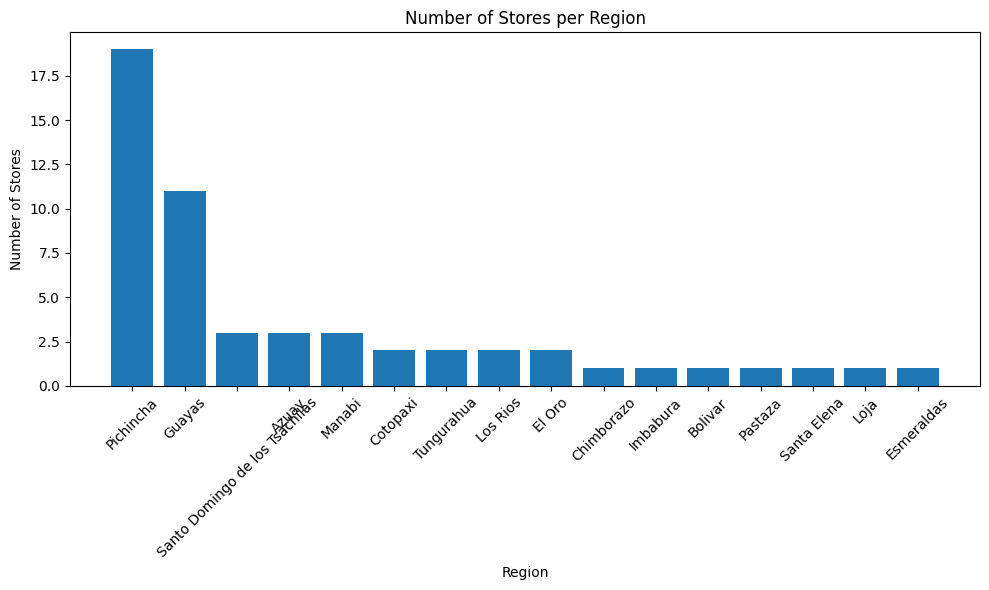

In [19]:
# Plotting the number of stores per region (state)
stores_per_region = df_stores['state'].value_counts().reset_index()
stores_per_region.columns = ['Region', 'Store Count']

plt.figure(figsize=(10, 6))
plt.bar(stores_per_region['Region'], stores_per_region['Store Count'])
plt.title("Number of Stores per Region")
plt.xlabel("Region")
plt.ylabel("Number of Stores")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

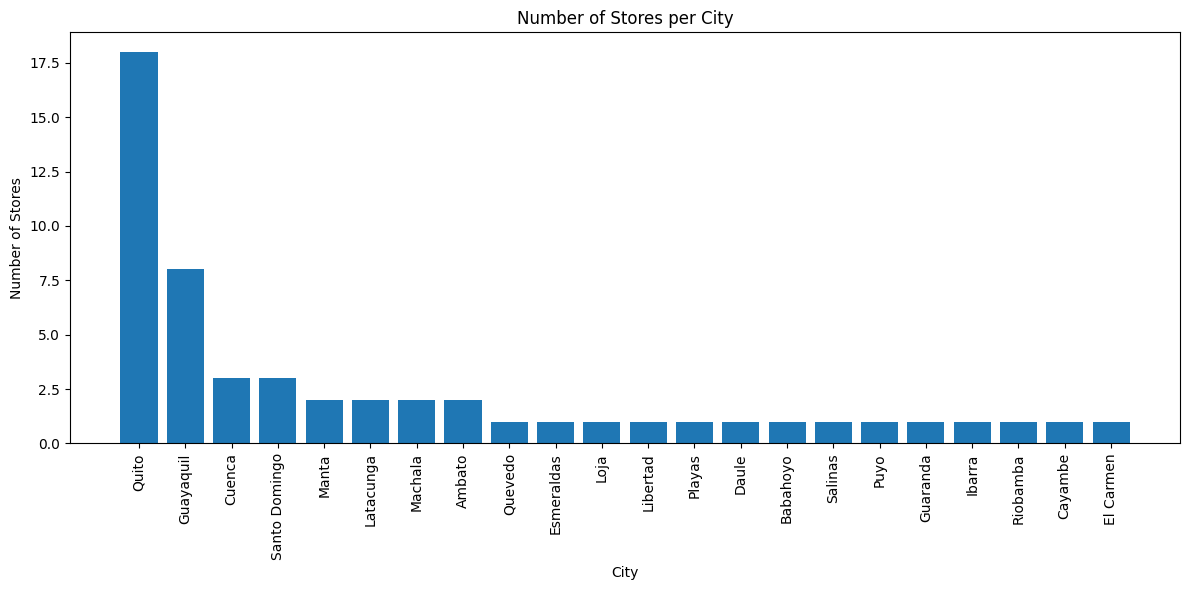

In [20]:
# Plotting the number of stores per city
stores_per_city = df_stores['city'].value_counts().reset_index()
stores_per_city.columns = ['City', 'Store Count']

plt.figure(figsize=(12, 6))
plt.bar(stores_per_city['City'], stores_per_city['Store Count'])
plt.title("Number of Stores per City")
plt.xlabel("City")
plt.ylabel("Number of Stores")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

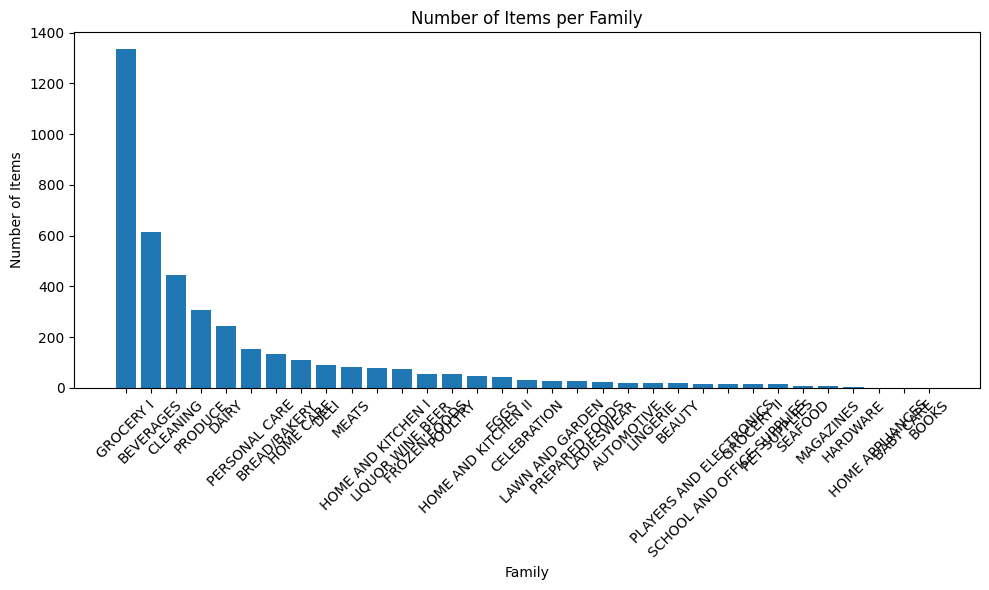

In [21]:
# Plotting the number of items per family
items_per_family = df_items['family'].value_counts().reset_index()
items_per_family.columns = ['Family', 'Item Count']

plt.figure(figsize=(10, 6))
plt.bar(items_per_family['Family'], items_per_family['Item Count'])
plt.title("Number of Items per Family")
plt.xlabel("Family")
plt.ylabel("Number of Items")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

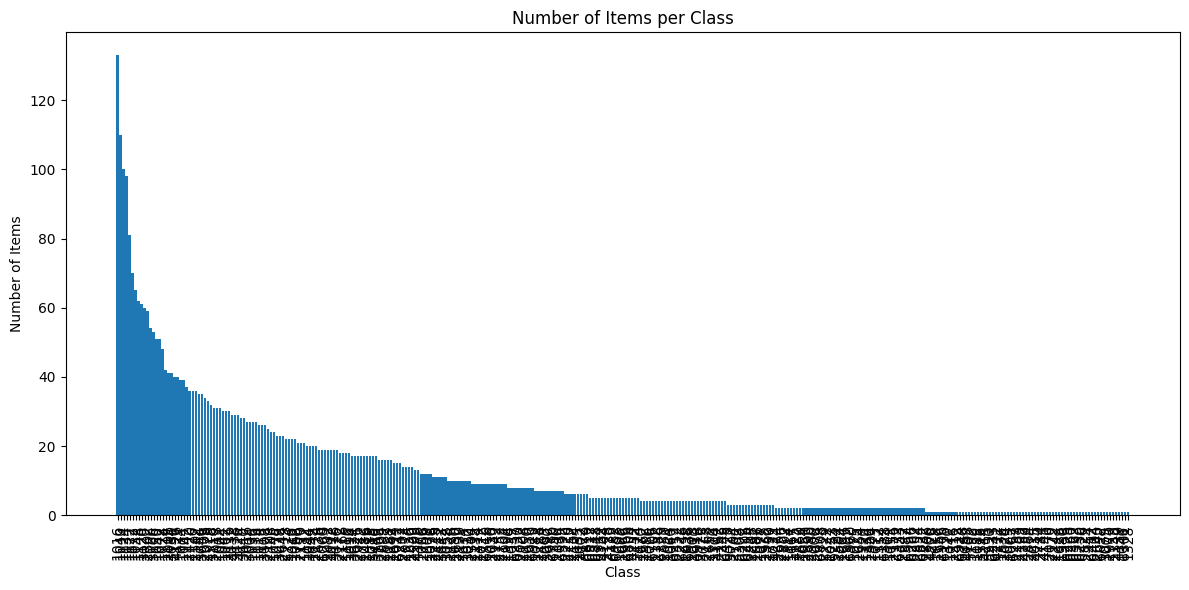

In [22]:
# Plotting the number of items per class
items_per_class = df_items['class'].value_counts().reset_index()
items_per_class.columns = ['Class', 'Item Count']

plt.figure(figsize=(12, 6))
plt.bar(items_per_class['Class'].astype(str), items_per_class['Item Count'])
plt.title("Number of Items per Class")
plt.xlabel("Class")
plt.ylabel("Number of Items")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

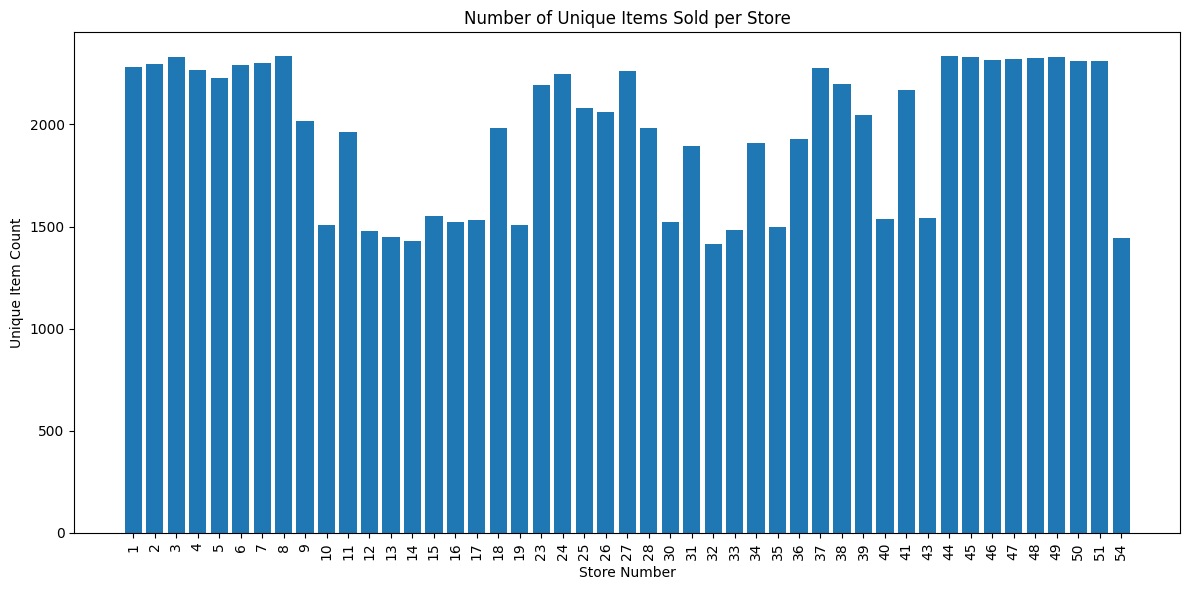

In [23]:
# Calculate the number of unique items per store in df_train
items_per_store = df_train.groupby('store_nbr')['item_nbr'].nunique().reset_index()
items_per_store.columns = ['Store Number', 'Unique Item Count']

# Plot the number of items per store
plt.figure(figsize=(12, 6))
plt.bar(items_per_store['Store Number'].astype(str), items_per_store['Unique Item Count'])
plt.title("Number of Unique Items Sold per Store")
plt.xlabel("Store Number")
plt.ylabel("Unique Item Count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Sales Over Time (Aggregated)

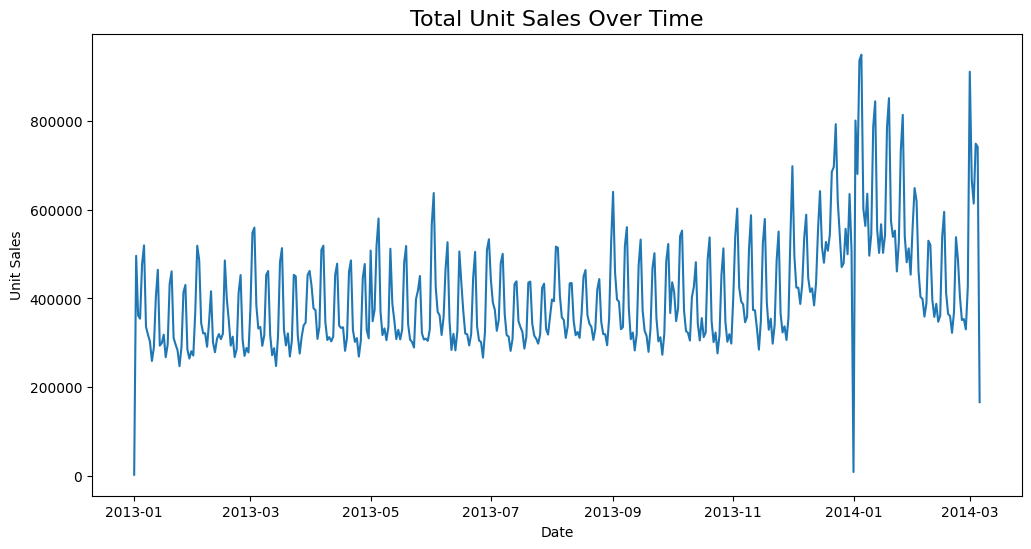

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregating total sales by date
sales_by_date = df_train.groupby('date')['unit_sales'].sum()

# Plotting the time-series
plt.figure(figsize=(12,6))
plt.plot(sales_by_date.index, sales_by_date.values)
plt.title('Total Unit Sales Over Time', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Unit Sales')
plt.show()

## Sales Trend by Year and Month

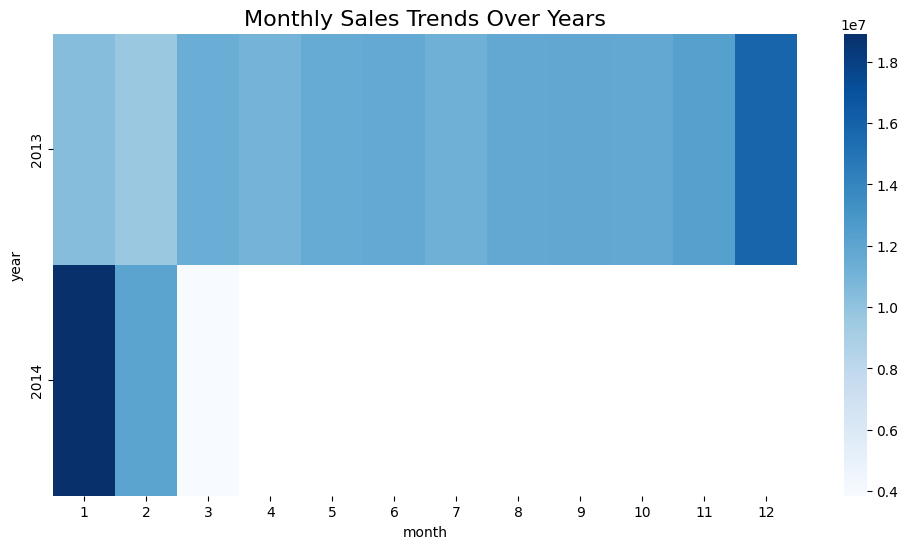

In [25]:
# Aggregating sales by year and month
sales_by_month = df_train.groupby(['year', 'month'])['unit_sales'].sum().unstack()

# Plotting heatmap of sales by year and month
import seaborn as sns

plt.figure(figsize=(12,6))
sns.heatmap(sales_by_month, cmap='Blues', annot=False, fmt='.0f')
plt.title('Monthly Sales Trends Over Years', fontsize=16)
plt.show()

## Effect of Promotions on Sales

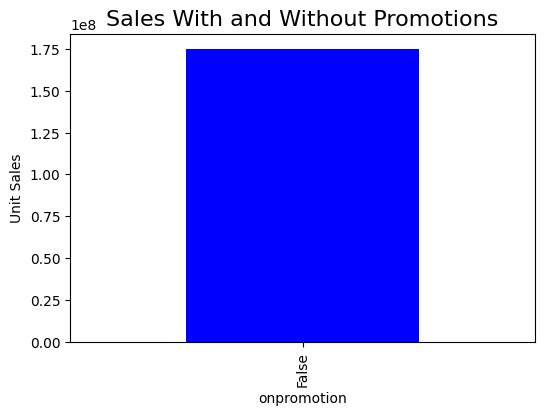

In [26]:
# Aggregating promotion and non-promotion sales
promo_sales = df_train.groupby('onpromotion')['unit_sales'].sum()

# Plotting
plt.figure(figsize=(6,4))
promo_sales.plot(kind='bar', color=['blue', 'orange'])
plt.title('Sales With and Without Promotions', fontsize=16)
plt.ylabel('Unit Sales')
plt.show()

# Investigating Relationship with Oil Prices

In [27]:
# Convert date column to datetime
#df_oil['date'] = pd.to_datetime(df_oil['date'])
#print("Oil prices range: from",df_oil['date'].dt.date.min(),"till",df_oil['date'].dt.date.max())

# Merging df_train with oil data on date
#df_train_oil = pd.merge(df_train, df_oil, on='date', how='left')

# Plotting oil price vs unit sales
#fig, ax1 = plt.subplots(figsize=(10,6))

#ax1.set_xlabel('Date')
#ax1.set_ylabel('Oil Price', color='tab:blue')
#ax1.plot(df_train_oil['date'], df_train_oil['dcoilwtico'], color='tab:blue', label='Oil Price')
#ax2 = ax1.twinx()
#ax2.set_ylabel('Unit Sales', color='tab:green')
#ax2.plot(df_train_oil['date'], df_train_oil['unit_sales'], color='tab:green', label='Unit Sales')

#plt.title('Oil Price vs Unit Sales Over Time', fontsize=16)
#plt.show()

# Examining the Impact of Holidays

Holidays range: from 2012-03-02 till 2017-12-26


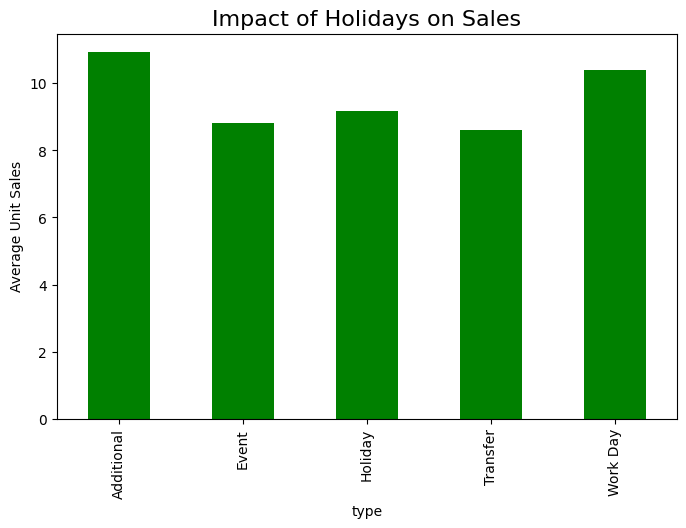

In [28]:
# Convert date column to datetime
df_holidays_events['date'] = pd.to_datetime(df_holidays_events['date'])
print("Holidays range: from",df_holidays_events['date'].dt.date.min(),"till",df_holidays_events['date'].dt.date.max())

# Merging df_train data with holidays
df_train_holiday = pd.merge(df_train, df_holidays_events, on='date', how='left')

# Aggregating sales by holiday and non-holiday
holiday_sales = df_train_holiday.groupby('type')['unit_sales'].mean()

# Plotting holiday impact
plt.figure(figsize=(8,5))
holiday_sales.plot(kind='bar', color='green')
plt.title('Impact of Holidays on Sales', fontsize=16)
plt.ylabel('Average Unit Sales')
plt.show()

# Analyzing Perishable Items

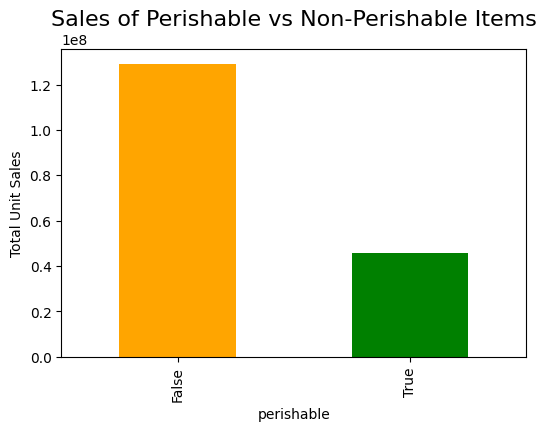

In [29]:
# Merging df_train with items to get perishable data
df_train_items = pd.merge(df_train, df_items, on='item_nbr', how='left')
df_train_items['perishable'] = df_train_items['perishable'].astype(bool)
# Aggregating sales by perishable and non-perishable items
perishable_sales = df_train_items.groupby('perishable')['unit_sales'].sum()

# Plotting sales for perishable and non-perishable items
plt.figure(figsize=(6,4))
perishable_sales.plot(kind='bar', color=['orange', 'green'])
plt.title('Sales of Perishable vs Non-Perishable Items', fontsize=16)
plt.ylabel('Total Unit Sales')
plt.show()

# Fill out missing dates with 0 sales

In [ ]:
import pandas as pd

# Convert 'date' column to datetime format
df_train['date'] = pd.to_datetime(df_train['date'])

# Get the minimum and maximum dates in the dataset to create a full date range
min_date = df_train['date'].min()
max_date = df_train['date'].max()

# Create a full date range covering all days between the min and max dates
full_date_range = pd.date_range(start=min_date, end=max_date, freq='D')

# Create an empty DataFrame to store the final result
df_filled = pd.DataFrame()

# Iterate through each store and item combination
for (store, item), group in df_train.groupby(['store_nbr', 'item_nbr']):
    # Set 'date' as index and sort by date
    group.set_index('date', inplace=True)
    group = group.sort_index()

    # Reindex to fill missing dates with 0 sales
    group = group.reindex(full_date_range, fill_value=0)

    # Keep track of the store and item number for each row
    group['store_nbr'] = store
    group['item_nbr'] = item

    # Ensure that missing sales values are filled with 0
    group['unit_sales'] = group['unit_sales'].fillna(0)

    # Append the group to the final DataFrame
    df_filled = pd.concat([df_filled, group])

# Reset the index to get 'date' back as a column
df_filled.reset_index(inplace=True)
df_filled.rename(columns={'index': 'date'}, inplace=True)

# Check the first few rows of the result
print(df_filled.head())


In [ ]:
df_filled[df_filled['unit_sales'] ==0]